In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
import numpy as np
import utils as u
from tqdm import tqdm
import random
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter

# VARIÁVEIS

In [3]:
IMG_SIZE = 100
BATCH_SIZE = 16

# Importando anotações

In [4]:
df = pd.read_csv('annotations.csv')
df_r = u.refatorar_anotacoes(df, img_size=IMG_SIZE) # refatora e coloca os bboxs em percentual da imagem
df_r.sample(3)

100%|██████████| 20000/20000 [00:01<00:00, 16257.81it/s]


,path,x0,y0,x1,y1
3952,./imgs/img_03952.jpg,33.628319,23.412698,61.946903,36.111111
4008,./imgs/img_04008.jpg,50.000000,50.884956,98.076923,73.008850
14661,./imgs/img_14661.jpg,41.304348,59.459459,66.847826,80.630631


# Analisando algumas imagens e sua marcação

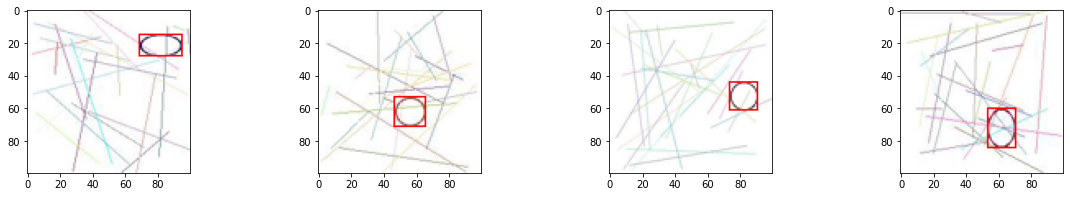

In [5]:
plt.figure(figsize=(20, 3))
for k in range(4):
    plt.subplot(1, 4, k+1)
    path, x0, y0, x1, y1 = df_r.sample().values[0]
    img_pil = Image.open(path).resize((IMG_SIZE, IMG_SIZE))
    draw = ImageDraw.Draw(img_pil)
    draw.rectangle([x0, y0, x1, y1], fill=None, outline='red', width=1)
    plt.imshow(img_pil)

plt.show()

# Criando um dataset customizado

In [7]:
transformer = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(.5, .5, .5), std=(.5, .5, .5))
])

class custom_dataset(Dataset):

    def __init__(self, df_: pd.DataFrame):
        self.df_ = df_.values
    
    def __getitem__(self, index):
        path, x0, y0, x1, y1 = self.df_[index]
        img_pil = Image.open(path)
        return transformer(img_pil), torch.tensor([x0, y0, x1, y1]) / IMG_SIZE  # <<<<< dividindo por 100
    
    def __len__(self):
        return len(self.df_)

dataset = custom_dataset(df_r)
print (f'{len(dataset)=}')
img_tensor, bbox = random.choice(dataset)
print (f'{img_tensor.shape=}, {bbox=}')

dataloader = DataLoader(dataset, batch_size=2, shuffle=True)
batch_imgs, batch_bbox = next(iter(dataloader))
print (f'{batch_imgs.shape=}, {batch_bbox.shape=}')

len(dataset)=20000
img_tensor.shape=torch.Size([3, 100, 100]), bbox=tensor([0.4150, 0.7268, 0.5340, 0.9180])
batch_imgs.shape=torch.Size([2, 3, 100, 100]), batch_bbox.shape=torch.Size([2, 4])


# Criando modelo

In [8]:
class Modelo(nn.Module):

    def __init__(self, img_batch, ncll=4):
        '''
        cll: (channels of last layer) - Numeros de canais da última camada de convolução
        '''
        super(Modelo, self).__init__()

        backbone = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=ncll*16, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(num_features=ncll*16),

            nn.Conv2d(in_channels=ncll*16, out_channels=ncll*8, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=ncll*8),

            nn.Conv2d(in_channels=ncll*8, out_channels=ncll*4, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=ncll*4),

            nn.Conv2d(in_channels=ncll*4, out_channels=ncll*2, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=ncll*2),

            nn.Conv2d(in_channels=ncll*2, out_channels=ncll, kernel_size=2, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(num_features=ncll),

            nn.Flatten()
        )

        output_backbone = backbone(img_batch)
        n_in = output_backbone.shape[-1]

        self.net = nn.Sequential(
            backbone,
            nn.Linear(in_features=n_in, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

model = Modelo(batch_imgs, ncll=8)
output = model(batch_imgs)
print (f'{output=}')

criterion = nn.MSELoss()
loss = criterion(output, batch_bbox)
print (f'{loss.item()=}')

output=tensor([[0.0184, 0.0000, 0.0663, 0.1563],
        [0.0000, 0.0000, 0.0435, 0.0534]], grad_fn=<ReluBackward0>)
loss.item()=0.3714648187160492


# Funções úteis

In [9]:
df_train, df_test = train_test_split(df_r, test_size=0.01, shuffle=True)

train_dataset = custom_dataset(df_train)
test_dataset = custom_dataset(df_test)
print (f'{len(train_dataset)=}, {len(test_dataset)=}')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print (f'{len(train_dataloader)=}, {len(test_dataloader)=}')

len(train_dataset)=19800, len(test_dataset)=200
len(train_dataloader)=1238, len(test_dataloader)=13


In [10]:
def validar(tdataloader, device_ = torch.device('cpu')):
    model.eval()
    with torch.no_grad():
        test_loss, total_itens = 0, 0
        for batch_imgs, batch_bbox in tqdm(tdataloader):
            batch_imgs, batch_bbox = batch_imgs.to(device_), batch_bbox.to(device_)
            output = model(batch_imgs)
            loss = criterion(output, batch_bbox)
            test_loss += loss.item()
            total_itens += len(batch_imgs)
    
    return (test_loss / total_itens)

validar(test_dataloader)

100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


0.025366091281175614

# Preparando para treinamento

In [16]:
df_train, df_test = train_test_split(df_r, test_size=0.05, shuffle=True)

train_dataset = custom_dataset(df_train)
test_dataset = custom_dataset(df_test)
print (f'{len(train_dataset)=}, {len(test_dataset)=}')

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

batch_imgs, batch_bboxes = next(iter(test_dataloader))

print (f'{len(train_dataloader)=}, {len(test_dataloader)=}')

modelo = Modelo(batch_imgs)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

model.to(device)
criterion = nn.MSELoss()
criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter('./logs/treinamento-1')
writer.add_text('texto', 'Treinamento com 20.000 imagens.')

len(train_dataset)=19000, len(test_dataset)=1000
len(train_dataloader)=1188, len(test_dataloader)=63
device=device(type='cuda', index=0)


# Treinamento

In [ ]:
for epoch in range(100):
    train_loss, total_itens = 0, 0
    clear_output(wait=True)
    print (f'{epoch=}')
    with torch.set_grad_enabled(True):
        for batch_imgs, batch_bboxes in tqdm(train_dataloader):
            batch_imgs, batch_bboxes = batch_imgs.to(device), batch_bboxes.to(device)
            
            model.zero_grad()
            output = model(batch_imgs)
            loss = criterion(output, batch_bboxes)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            total_itens += len(batch_imgs)
    
    train_loss = train_loss / total_itens
    
    test_loss = validar(test_dataloader, device)
    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)

In [25]:
writer.close()

In [19]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'epochs': 31
}
torch.save(checkpoint, 'checkpoint.pt')

# Avaliação de uma imagem

In [20]:
model.eval()
print ('ok')

def cor_aleatoria(clara=True):
    if (clara):
        return random.randint(100, 255), random.randint(100, 255), random.randint(100, 255)
    else:
        return random.randint(0, 150), random.randint(0, 150), random.randint(0, 150)

def criar_imagem():

    size_min, size_max = 100, 300
    radius_min, radius_max = 30, 50
    
    w, h = random.randint(size_min, size_max), random.randint(size_min, size_max)
    
    img_pil = Image.new('RGB', (w, h), color='white')
    draw = ImageDraw.Draw(img_pil)

    for _ in range(25):
        draw.line((random.randint(0, w), random.randint(0, h), random.randint(0, w), random.randint(0, h)), width=1, fill=cor_aleatoria())
    
    radius = random.randint(radius_min, radius_max)
    xmin, ymin, xmax, ymax = radius, radius, w-radius, h-radius
    x, y = random.randint(xmin, xmax), random.randint(ymin, ymax)

    bbox = [x, y, x+radius, y+radius]
    draw.ellipse(bbox, fill=None, outline=cor_aleatoria(clara=False), width=2)

    #draw.rectangle(bbox, fill=None, outline='red', width=1)
    # desenha o bbox apenas para análise
    
    return img_pil, bbox

ok


[68.6608   27.019627 94.74346  46.162064]


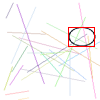

In [28]:
img_pil, _ = criar_imagem()
img_tensor = transformer(img_pil).to(device)

bbox = model(img_tensor.unsqueeze_(0))
bbox = bbox.detach().cpu().numpy()[0] * IMG_SIZE
print (bbox)

img_pil = img_pil.resize((IMG_SIZE, IMG_SIZE))
draw = ImageDraw.Draw(img_pil)
draw.rectangle(bbox, fill=None, outline='red', width=1)
img_pil

w=200, h=266
saída do modelo: bbox=tensor([[0.6169, 0.2487, 0.8485, 0.4217]], device='cuda:0',
       grad_fn=<ReluBackward0>) já representa o próprio percentual


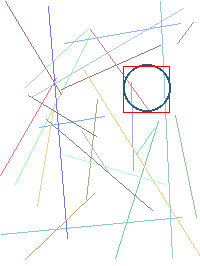

In [50]:
img_pil, _ = criar_imagem()
img_tensor = transformer(img_pil).to(device)
w, h = img_pil.size
print (f'{w=}, {h=}')

bbox = model(img_tensor.unsqueeze_(0))
print (f'saída do modelo: {bbox=} já representa o próprio percentual')
x0, y0, x1, y1 = bbox.detach().cpu().numpy()[0]
bbox = [x0*(w), y0*(h), x1*(w), y1*(h)]

draw = ImageDraw.Draw(img_pil)
draw.rectangle(bbox, fill=None, outline='red', width=1)
img_pil